In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
import pickle
import joblib
import os
from sklearn import tree as tr

In [2]:
def load_model(model_path):
    with open(model_path, 'rb') as f:
        return pickle.load(f)

def load_dataset(folder_name):
    with open(f'../data/{folder_name}/train.pkl', 'rb') as f:
        X_train, y_train = pickle.load(f)
    with open(f'../data/{folder_name}/val.pkl', 'rb') as f:
        X_val, y_val = pickle.load(f)
    with open(f'../data/{folder_name}/test.pkl', 'rb') as f:
        X_test, y_test = pickle.load(f)

    scaler_y = None
    if folder_name in ['norm', 'hot_norm']:
        with open(f'../data/scaler_y.pkl', 'rb') as f:
            scaler_y = pickle.load(f)
    
    return X_train, X_val, X_test, y_train, y_val, y_test, scaler_y

In [3]:
file_name = '../data/rf_performances.csv'
perf_df = pd.read_csv(file_name)

In [4]:

# Define the regular expression pattern to extract n_estimators, max_depth, min_samples_split, and min_samples_leaf
pattern_rf = r'rf_(\d+)_estimators_(\d+)_depth_(\d+)_minsplit_(\d+)_minleaf_'
# Extract the values using the pattern
perf_df[['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf']] = perf_df['model_path'].str.extract(pattern_rf)
# Convert the extracted values to appropriate types
perf_df['n_estimators'] = perf_df['n_estimators'].astype(int)
perf_df['max_depth'] = perf_df['max_depth'].astype(int)
perf_df['min_samples_split'] = perf_df['min_samples_split'].astype(int)
perf_df['min_samples_leaf'] = perf_df['min_samples_leaf'].astype(int)

perf_df


,model,dataset,split,rmse,mae,r2,inversed,model_path,max_depth,min_samples_split,min_samples_leaf
0,"DecisionTreeRegressor (max_depth=None, min_sam...",hot,train,0.0000,0.0000,1.0000,False,../models/dt_None_depth_2_minsplit_1_minleaf_h...,NaN,2,1
1,"DecisionTreeRegressor (max_depth=None, min_sam...",hot,val,114.8430,57.6718,0.6155,False,../models/dt_None_depth_2_minsplit_1_minleaf_h...,NaN,2,1
2,"DecisionTreeRegressor (max_depth=None, min_sam...",hot,test,118.9618,59.2619,0.5933,False,../models/dt_None_depth_2_minsplit_1_minleaf_h...,NaN,2,1
3,"DecisionTreeRegressor (max_depth=None, min_sam...",hot,train,67.6970,38.9204,0.8659,False,../models/dt_None_depth_2_minsplit_5_minleaf_h...,NaN,2,5
4,"DecisionTreeRegressor (max_depth=None, min_sam...",hot,val,109.4714,64.8469,0.6506,False,../models/dt_None_depth_2_minsplit_5_minleaf_h...,NaN,2,5
...,...,...,...,...,...,...,...,...,...,...,...
235,"DecisionTreeRegressor (max_depth=40, min_sampl...",hot,val,108.3939,65.8845,0.6575,False,../models/dt_40_depth_30_minsplit_10_minleaf_h...,40.0,30,10
236,"DecisionTreeRegressor (max_depth=40, min_sampl...",hot,test,109.0205,67.4627,0.6585,False,../models/dt_40_depth_30_minsplit_10_minleaf_h...,40.0,30,10
237,"DecisionTreeRegressor (max_depth=40, min_sampl...",hot,train,93.6564,57.7775,0.7433,False,../models/dt_40_depth_30_minsplit_20_minleaf_h...,40.0,30,20
238,"DecisionTreeRegressor (max_depth=40, min_sampl...",hot,val,109.0475,66.7368,0.6533,False,../models/dt_40_depth_30_minsplit_20_minleaf_h...,40.0,30,20


In [5]:
# Drop all rows where column 'split' = 'test'
perf_df = perf_df[perf_df['split'] != 'test']

# Ensure the 'split' column has a categorical type with the specified order
split_order = pd.CategoricalDtype(categories=['val', 'train'], ordered=True)
perf_df['split'] = perf_df['split'].astype(split_order)

# Split the DataFrame into inversed and non-inversed
inversed_df = perf_df[perf_df['inversed'] == True]
NOT_inversed_df = perf_df[perf_df['inversed'] == False]

/tmp/ipykernel_1748/2902005474.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perf_df['split'] = perf_df['split'].astype(split_order)


# Mae

In [6]:
# Sort the DataFrame by 'split' and then by 'mae'
mae_sorted_df = NOT_inversed_df.sort_values(by=['split', 'mae'], ascending=[True, False])

In [7]:
mae_sorted_df['model_path'].values[0]

'../models/dt_10_depth_2_minsplit_20_minleaf_hot.pkl'

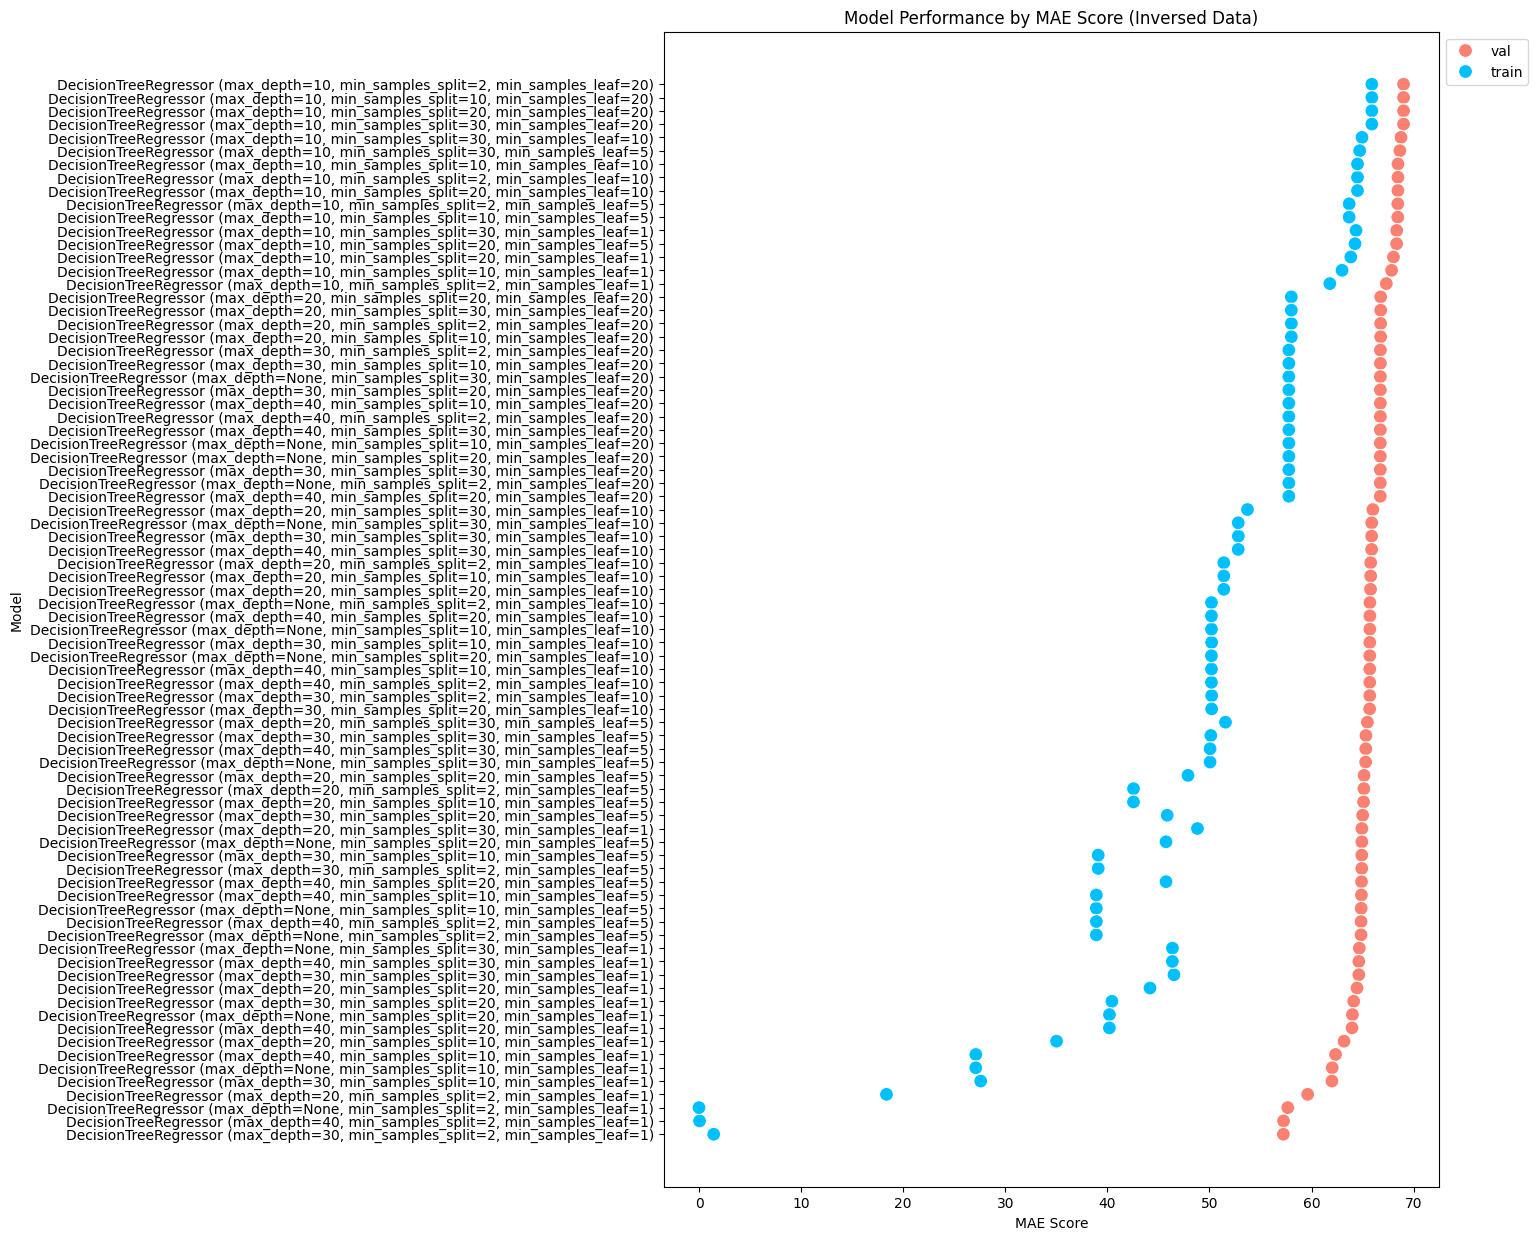

In [8]:
# Plot for Filtered Data
plt.figure(figsize=(10, 15))
sns.scatterplot(data=mae_sorted_df, 
                y='model', 
                x='mae', 
                palette={'train': 'deepskyblue', 'val': 'salmon'},# Custom color palette
                marker='o',   # Circle markers
                s=100,        # Size of the markers
                hue='split'   # Color by split
                )  

# Adding plot title
plt.title('Model Performance by MAE Score')

# Adding x and y axis labels
plt.xlabel('MAE Score')
plt.ylabel('Model')

plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

# Save plot
#plt.savefig('../plots/filtered_models_MAE.png')
# Display the plot
plt.show()


# R2

In [9]:
# Sort the DataFrame by 'split' and then by 'r2'
r2_sorted_df = NOT_inversed_df.sort_values(by=['split', 'r2'], ascending=[True, True])

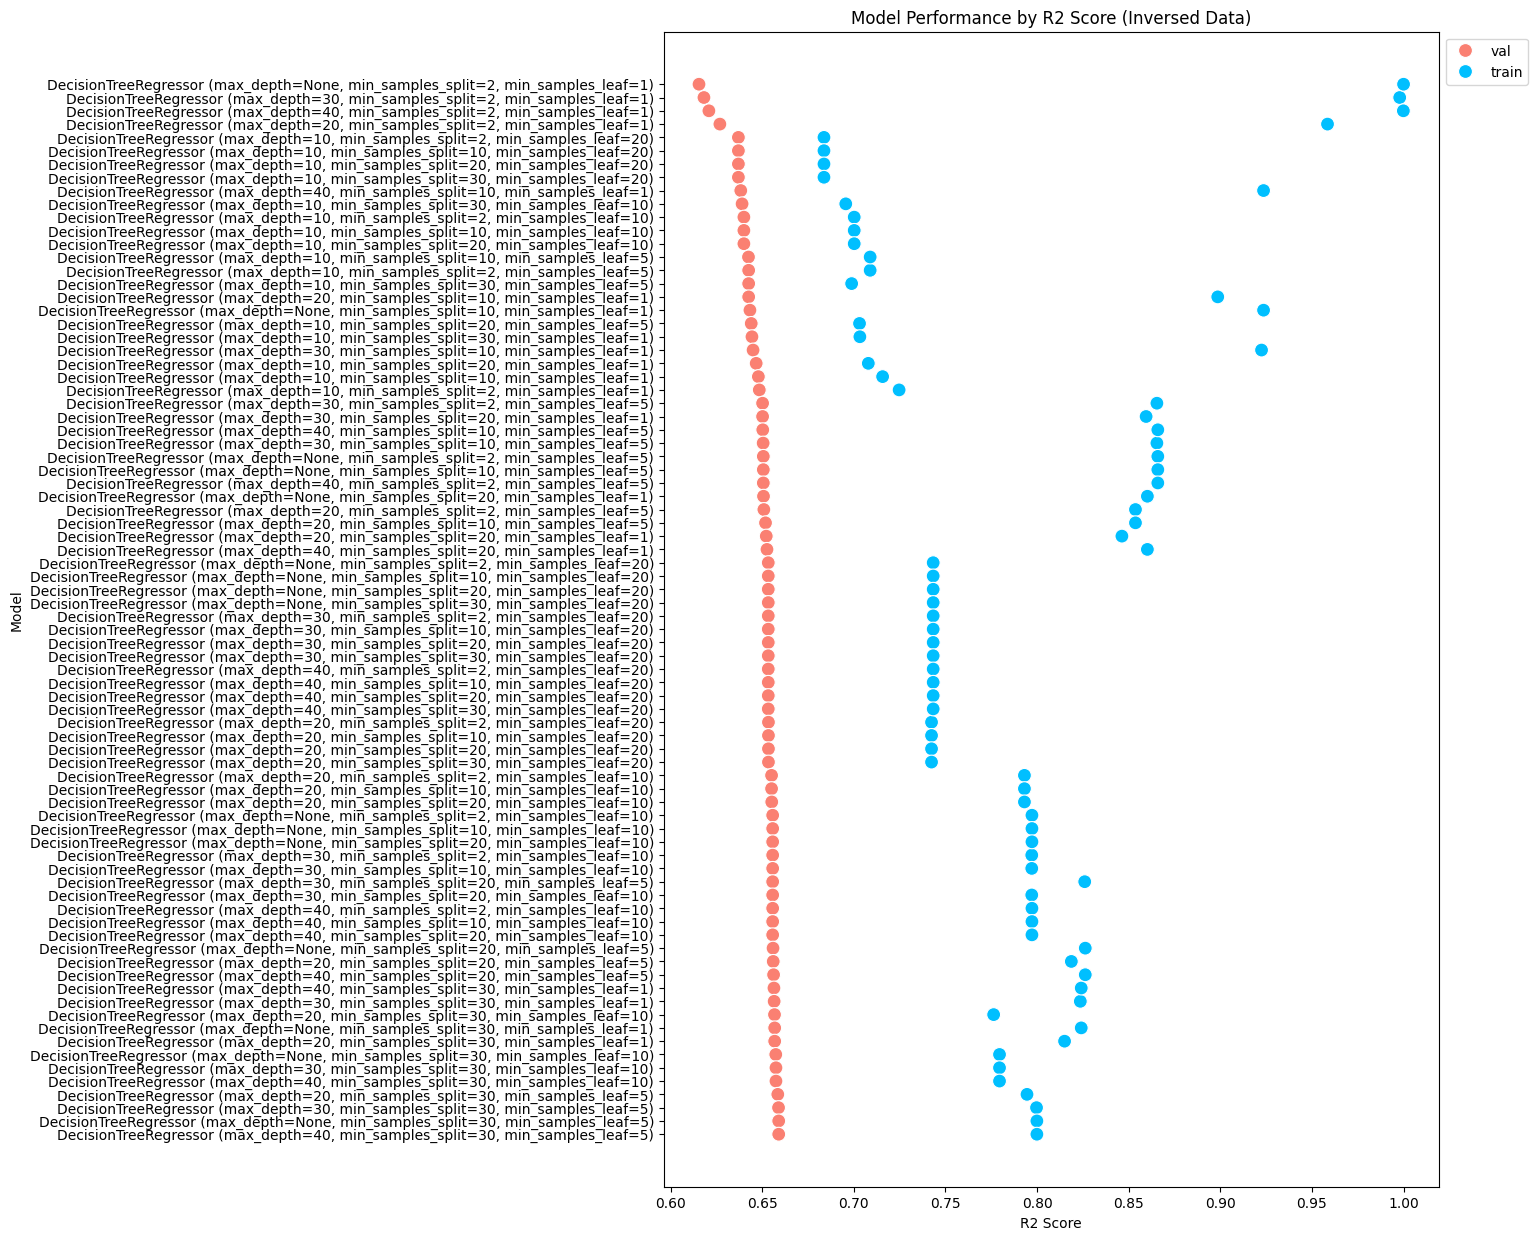

In [10]:
# Plot for Filtered Data
plt.figure(figsize=(10, 15))
sns.scatterplot(data=r2_sorted_df, 
                y='model', 
                x='r2', 
                palette={'train': 'deepskyblue', 'val': 'salmon'},# Custom color palette
                marker='o',   # Circle markers
                s=100,        # Size of the markers
                hue='split'   # Color by split
                )  

# Adding plot title
plt.title('Model Performance by R2 Score')

# Adding x and y axis labels
plt.xlabel('R2 Score')
plt.ylabel('Model')

plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

# Save plot
#plt.savefig('../plots/filtered_models_R2.png')
# Display the plot
plt.show()


# RMSE

In [11]:
# Sort the DataFrame by 'split' and then by 'rmse'
rmse_sorted_df = NOT_inversed_df.sort_values(by=['split', 'rmse'], ascending=[True, False])

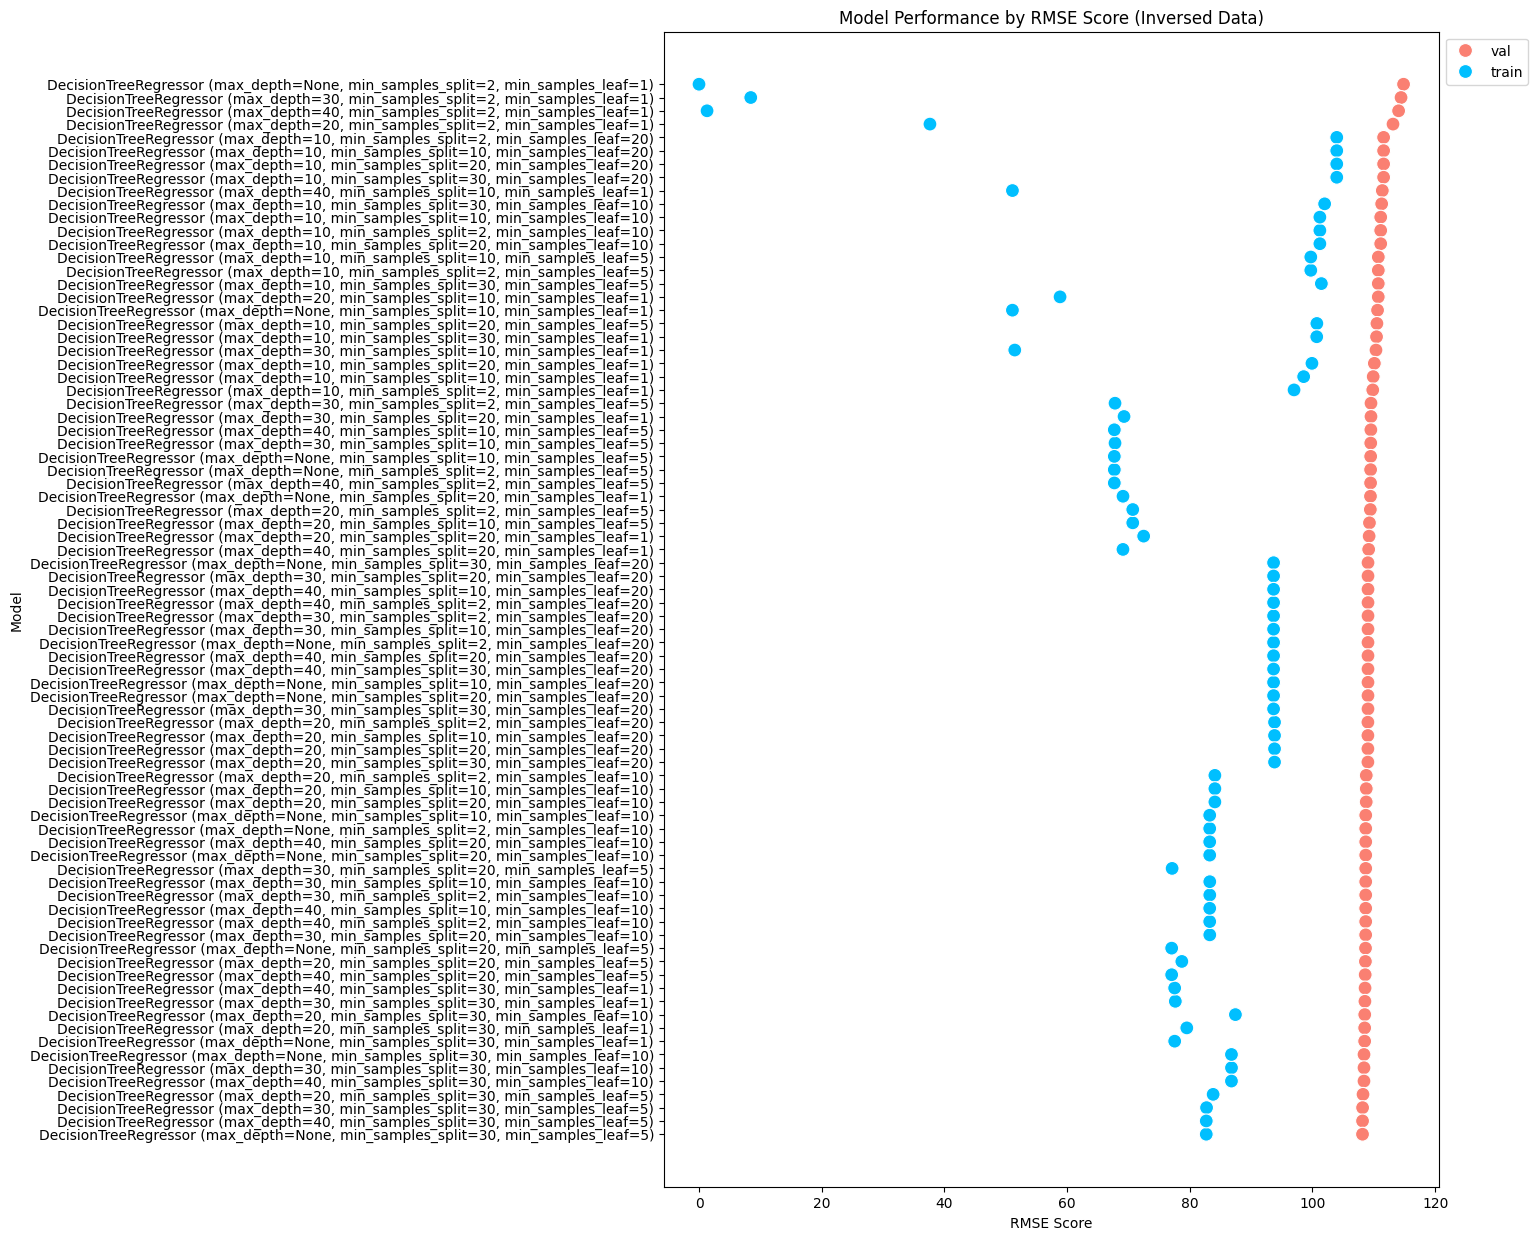

In [12]:
# Plot for Filtered Data
plt.figure(figsize=(10, 15))
sns.scatterplot(data=rmse_sorted_df, 
                y='model', 
                x='rmse', 
                palette={'train': 'deepskyblue', 'val': 'salmon'},# Custom color palette
                marker='o',   # Circle markers
                s=100,        # Size of the markers
                hue='split'   # Color by split
                )  

# Adding plot title
plt.title('Model Performance by RMSE Score')

# Adding x and y axis labels
plt.xlabel('RMSE Score')
plt.ylabel('Model')

plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

# Save plot
#plt.savefig('../plots/filtered_models_R2.png')
# Display the plot
plt.show()


# Performance over max depth

In [13]:
# keep only split = val
lineplot_df = NOT_inversed_df[NOT_inversed_df['split'] == 'val']

## Mae

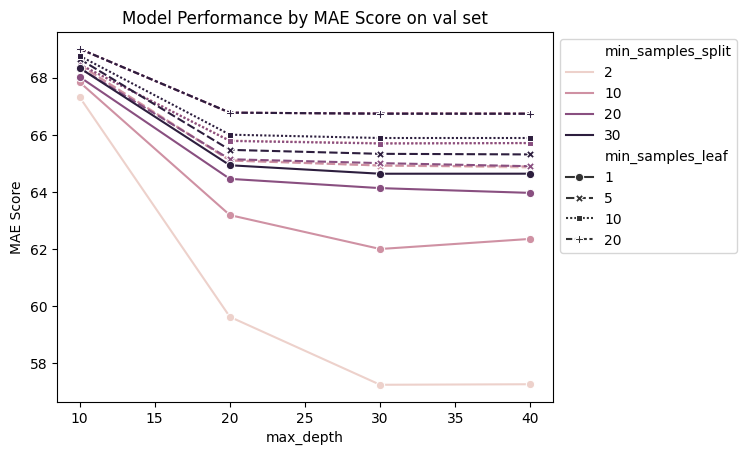

In [14]:
# ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf']

# Make one plot for each of the n_estimators (100, 200, 300)
for n_estimators in lineplot_df['n_estimators'].unique():
    # Filter the DataFrame to only include models with the current n_estimators
    n_estimators_df = lineplot_df[lineplot_df['n_estimators'] == n_estimators]
    # Plot the data
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=n_estimators_df, x='max_depth', y='mae', hue='min_samples_split', style='min_samples_leaf', markers=True, dashes=True)
                
    # Adding plot title
    plt.title(f'Model Performance by MAE Score on val set with {n_estimators} n_estimators')
    # Adding x and y axis labels
    plt.xlabel('max_depth')
    plt.ylabel('MAE Score')

    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

    # Display the plot
    plt.show()

## R2

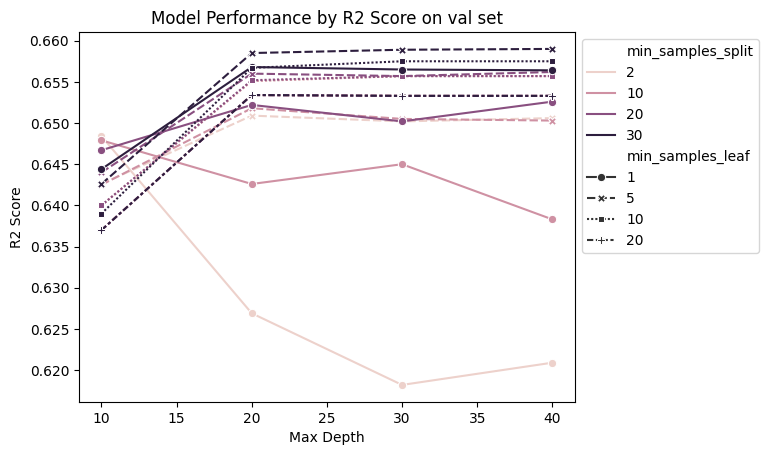

In [15]:
sns.lineplot(data=lineplot_df, x='max_depth', y='r2', hue='min_samples_split', style='min_samples_leaf', markers=True, dashes=True)# Adding plot title
plt.title('Model Performance by R2 Score on val set')
# Adding x and y axis labels
plt.xlabel('Max Depth')
plt.ylabel('R2 Score')

plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

## RMSE

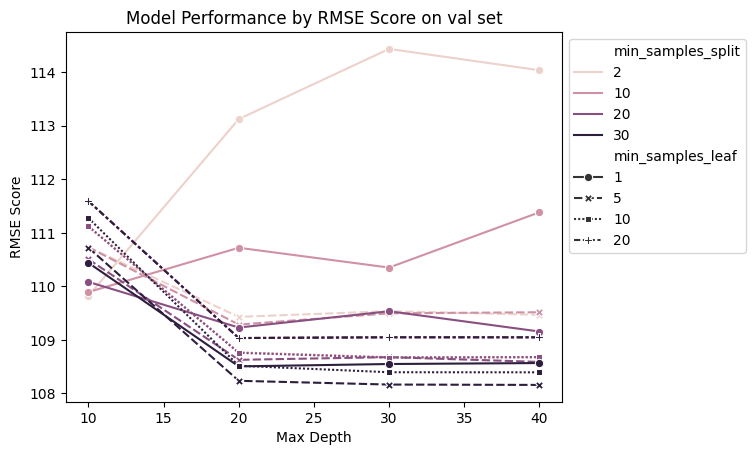

In [16]:
sns.lineplot(data=lineplot_df, x='max_depth', y='rmse', hue='min_samples_split', style='min_samples_leaf', markers=True, dashes=True)
# Adding plot title
plt.title('Model Performance by RMSE Score on val set')
# Adding x and y axis labels
plt.xlabel('Max Depth')
plt.ylabel('RMSE Score')

plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

# Best model

In [42]:
# Load dt model max depth 40, min_samples_split 30, min_samples_leaf 5
best_model_path = '../models/dt_40_depth_30_minsplit_5_minleaf_hot.pkl'
model = load_model(best_model_path)
# Make predictions on test set
X_train, X_val, X_test, y_train, y_val, y_test, scaler_y = load_dataset('hot')
preds = model.predict(X_test)

preds = preds.reshape(-1, 1).flatten()
# turn y_test into a numpy array
y_test = y_test.to_numpy()
# flatten y_test
y_test = y_test.reshape(-1, 1).flatten()

# turn y_train into a numpy array
y_train = y_train.to_numpy()
# flatten y_train
y_train = y_train.reshape(-1, 1).flatten()


In [18]:

# print their shape
print(preds.shape)
print(y_test.shape)

(7718,)
(7718,)


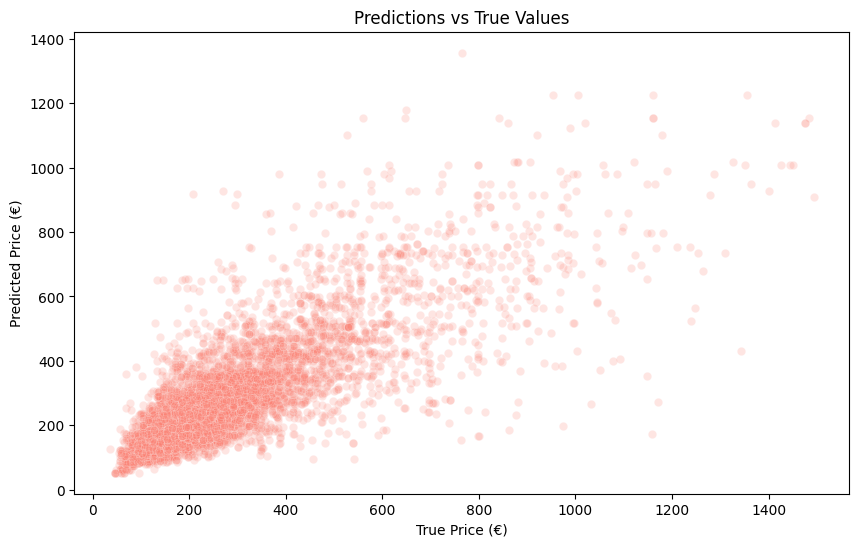

In [19]:
# Plot the predictions
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=preds, color='salmon', alpha=0.2)
plt.xlabel('True Price (€)')
plt.ylabel('Predicted Price (€)')
plt.title('Predictions vs True Values')
plt.show()

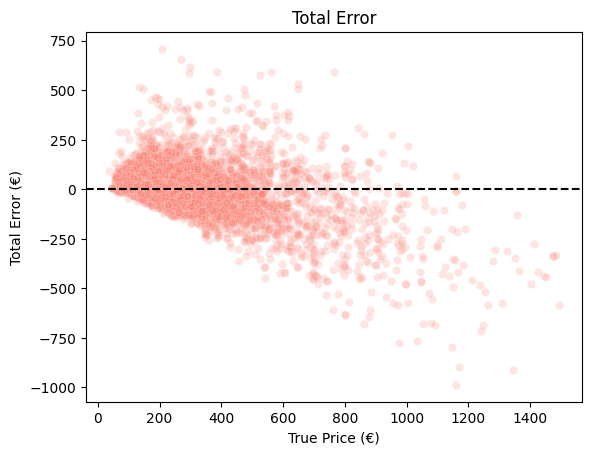

In [20]:
# Calculation of total error
total_error = preds - y_test

# Create scatter plot of predictions vs true values
sns.scatterplot(x=y_test, y=total_error, color='salmon', alpha=0.2)

# Add a horizontal line at y=0
plt.axhline(0, color='black', linestyle='--')

# Set the title and labels of the plot
plt.title('Total Error')
plt.xlabel('True Price (€)')
plt.ylabel('Total Error (€)')

# Show the plot
plt.show()

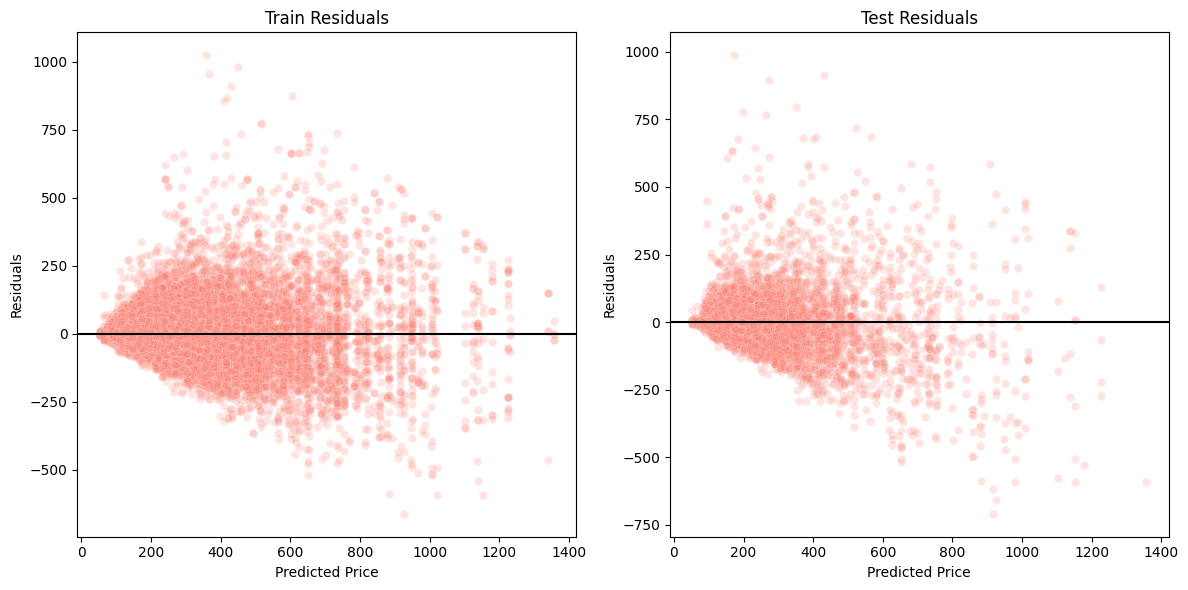

In [48]:

# Calculate residuals
y_train_pred = model.predict(X_train)
train_residuals = y_train - y_train_pred

y_test_pred = model.predict(X_test)
test_residuals = y_test - y_test_pred

# Plot residuals
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x=y_train_pred, y=train_residuals, color='salmon', alpha=0.2)
plt.axhline(0, color='black')
plt.title('Train Residuals')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test_pred, y=test_residuals, color='salmon', alpha=0.2)
plt.axhline(0, color='black')
plt.title('Test Residuals')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()


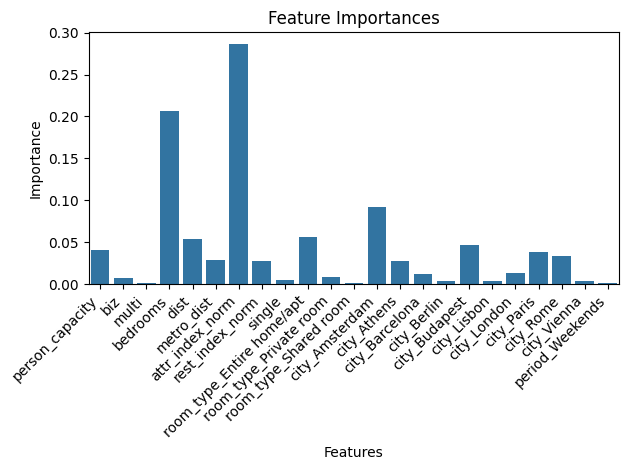

In [29]:
# Get feature importances
importances = model.feature_importances_


features = X_train.columns.tolist()

# Plot feature importances
sns.barplot(x=features, y=importances)
plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
# Rotate the x labels
plt.xticks(rotation=45, ha='right')
plt.tight_layout()  # Adjust the layout to make room for the rotated labels

plt.show()

In [24]:
perf_df = pd.read_csv(file_name)
best_df = perf_df[perf_df['model_path']==best_model_path]
best_df

,model,dataset,split,rmse,mae,r2,inversed,model_path
231,"DecisionTreeRegressor (max_depth=40, min_sampl...",hot,train,82.6828,50.0580,0.7999,False,../models/dt_40_depth_30_minsplit_5_minleaf_ho...
232,"DecisionTreeRegressor (max_depth=40, min_sampl...",hot,val,108.1586,65.3091,0.6590,False,../models/dt_40_depth_30_minsplit_5_minleaf_ho...
233,"DecisionTreeRegressor (max_depth=40, min_sampl...",hot,test,109.3493,66.9717,0.6564,False,../models/dt_40_depth_30_minsplit_5_minleaf_ho...
